In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.metrics import silhouette_score, r2_score, recall_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.cluster import KMeans 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier, Ridge

from catboost import CatBoostRegressor, CatBoostClassifier

import warnings

sns.set_style('whitegrid')
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

%matplotlib inline

/Users/salavat/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
def to_time_of_day(date):
    hour = date.hour
    if hour <= 5 or hour >= 21:
        return 'night'
    elif hour > 5 and hour < 10:
        return 'morning'
    elif hour < 16:
        return 'day'
    else:
        return 'evening'

In [3]:
df = pd.read_csv('train_dataset_train.csv')
df['pass_dttm'] = pd.to_datetime(df['pass_dttm'])
df['weekday'] = df.pass_dttm.dt.weekday
df['workday'] = df['weekday'].apply(lambda d: d < 5)
df['time_of_day'] = df.pass_dttm.apply(to_time_of_day)

In [4]:
df.head()

,id,ticket_id,ticket_type_nm,entrance_id,entrance_nm,station_id,station_nm,line_id,line_nm,pass_dttm,time_to_under,label,weekday,workday,time_of_day
0,1,40BD89EC85646EFB69E283F39C298E60,Пропуск FacePay,2402,Лефортово БКЛ,11007,Лефортово,11,Большая кольцевая,2022-09-12 05:00:13,216.316667,8001,0,True,night
1,2,126727A96489CC976A8C08E5CEB00542,СК учащегося 30 дней,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:00:54,648.183333,9011,0,True,night
2,3,D28CE6A9E0E5B6D213470A97CFF32485,БСК дружинника г.Москвы,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:00:55,865.333333,7022,0,True,night
3,4,015DA44B523C062B5BFEFF3FB0E64B9E,30 дней,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:01:13,1048.233333,2022,0,True,night
4,5,95B19C6F3A504727AC3EA56EB7E3E80F,КОШЕЛЕК,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:02:55,965.600000,2017,0,True,night


In [5]:
df.time_to_under.describe()

count    1.091021e+06
mean     5.104668e+02
std      2.328452e+02
min      3.001667e+01
25%      3.229500e+02
50%      5.686833e+02
75%      6.838833e+02
max      1.437417e+03
Name: time_to_under, dtype: float64

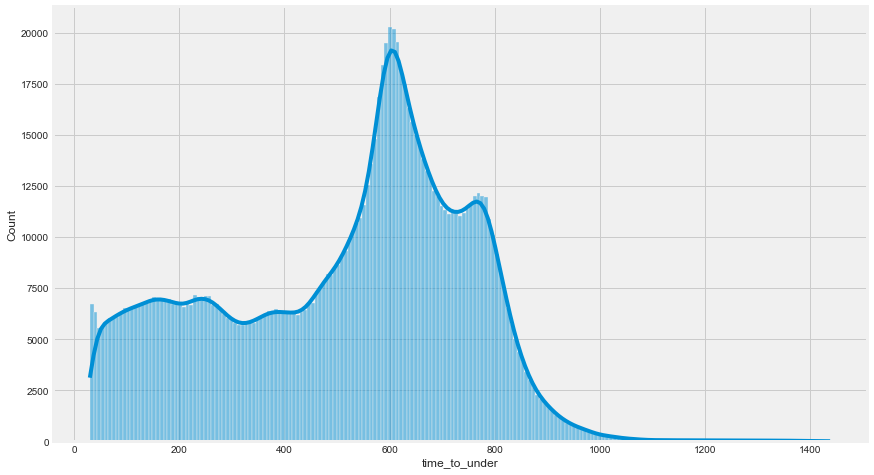

In [6]:
plt.figure(figsize=(13, 8))
sns.histplot(df.time_to_under, kde=True);

In [7]:
df.label.value_counts()

3002     17272
6008     15541
1022     13758
5010     13122
7022     13080
         ...  
13002       24
13003       23
13006       17
13005       14
13004        7
Name: label, Length: 276, dtype: int64

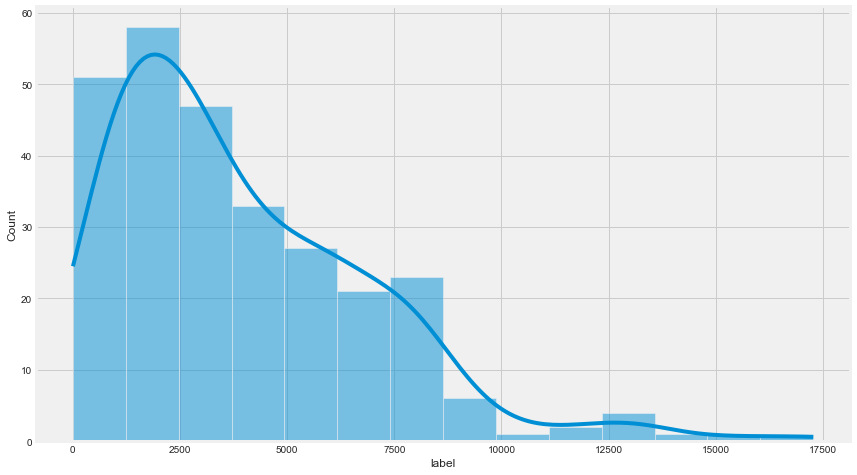

In [8]:
plt.figure(figsize=(13, 8))
sns.histplot(df.label.value_counts(), kde=True);

In [9]:
mean_time = df[['station_id', 'time_to_under']].groupby('station_id')['time_to_under'].mean()
mean_time = pd.DataFrame(mean_time)

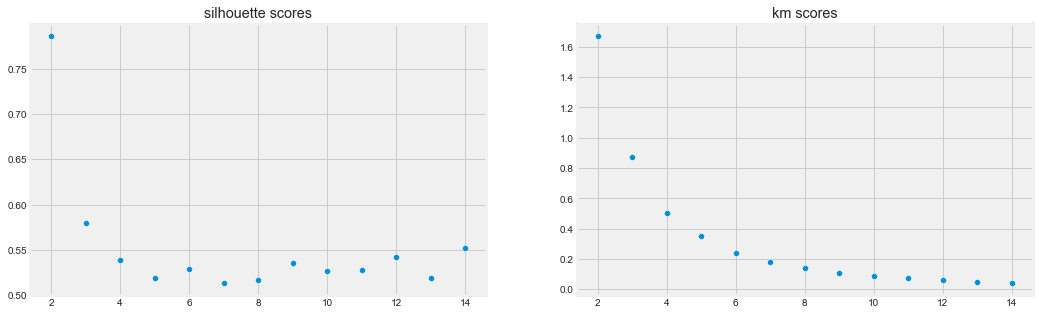

In [10]:
scaler = MinMaxScaler()
mean_time_scaled = scaler.fit_transform(mean_time)

km_silhouette_score = []
km_scores = []

for i in range(2, 15):
    km = KMeans(i, random_state=0).fit(mean_time_scaled)
    km_scores.append(-km.score(mean_time_scaled))
    pred = km.predict(mean_time_scaled)
    km_silhouette_score.append(silhouette_score(mean_time_scaled, pred))

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16,5))
sns.scatterplot(list(range(2, 15)), km_silhouette_score, ax=ax0).set(title='silhouette scores')
sns.scatterplot(list(range(2, 15)), km_scores).set(title='km scores');

In [11]:
mean_time['gr'] = KMeans(3).fit_predict(mean_time_scaled)

In [12]:
mean_time.head()

,time_to_under,gr
station_id,,
1002,525.912888,1
1003,476.660246,1
1004,478.434350,1
1005,536.724579,2
1006,475.592827,1


In [13]:
def agg(group):
    return {
        'count': group.count(),
        'mean': group.mean(),
        'std': group.std(),
        'min': group.min(),
        'max': group.max()
    }

In [14]:
gr_info = mean_time.groupby('gr')['time_to_under'].apply(agg).unstack()
gr_info.sort_values('count', inplace=True)
gr_info.index = range(3)
gr_info.index.name = 'gr'
gr_info

,count,mean,std,min,max
gr,,,,,
0,9.0,302.191767,82.888957,153.693750,387.494072
1,51.0,563.019276,34.366272,527.753937,668.639611
2,216.0,491.321845,23.358487,412.065319,526.914532


In [15]:
mean_time

,time_to_under,gr
station_id,,
1002,525.912888,1
1003,476.660246,1
1004,478.434350,1
1005,536.724579,2
1006,475.592827,1
...,...,...
81012,504.550115,1
81013,507.113493,1
81014,614.180661,2


In [16]:
stations_gr_stat = mean_time.join(gr_info, 'gr')[['mean', 'std', 'min', 'max']]
stations_gr_stat.head(2)

,mean,std,min,max
station_id,,,,
1002,563.019276,34.366272,527.753937,668.639611
1003,563.019276,34.366272,527.753937,668.639611


In [17]:
df = df.join(stations_gr_stat, 'station_id')
df.head(2)

,id,ticket_id,ticket_type_nm,entrance_id,entrance_nm,station_id,station_nm,line_id,line_nm,pass_dttm,time_to_under,label,weekday,workday,time_of_day,mean,std,min,max
0,1,40BD89EC85646EFB69E283F39C298E60,Пропуск FacePay,2402,Лефортово БКЛ,11007,Лефортово,11,Большая кольцевая,2022-09-12 05:00:13,216.316667,8001,0,True,night,302.191767,82.888957,153.693750,387.494072
1,2,126727A96489CC976A8C08E5CEB00542,СК учащегося 30 дней,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:00:54,648.183333,9011,0,True,night,563.019276,34.366272,527.753937,668.639611


In [18]:
counts = df.groupby('ticket_id').size().sort_values(ascending=False)
counts.head()

ticket_id
15A93BB90FA63B7D1910B4C72EEA8AC6    8
7992E92F9AE0F7506BD439547FD7E11F    8
18572BB4547B65C8DE530F7EE3A4875B    7
4548339BF47C8A6A48668256F2536113    7
8384F5FD62C4F533FD987862F9D1ECC1    7
dtype: int64

In [19]:
df[df.ticket_id == '15A93BB90FA63B7D1910B4C72EEA8AC6'][['entrance_id', 'station_id', 'pass_dttm', 'time_to_under', 'weekday', 'label']]

,entrance_id,station_id,pass_dttm,time_to_under,weekday,label
2451,310,7003,2022-09-12 05:49:30,892.350000,0,9018
219001,366,9016,2022-09-13 07:45:01,787.966667,1,9018
421875,366,9016,2022-09-14 08:30:04,705.716667,2,9018
569346,366,9016,2022-09-15 08:04:48,836.150000,3,9018
708592,366,9016,2022-09-16 07:21:58,808.033333,4,9018
902175,366,9016,2022-09-17 09:43:23,749.466667,5,7008
1003239,378,9018,2022-09-18 08:26:40,602.966667,6,7007
1090920,366,9016,2022-09-19 00:18:40,40.750000,0,9014


In [20]:
df[df.ticket_id == '7992E92F9AE0F7506BD439547FD7E11F'][['entrance_id', 'station_id', 'pass_dttm', 'time_to_under', 'weekday', 'label']]

,entrance_id,station_id,pass_dttm,time_to_under,weekday,label
22942,2043,3018,2022-09-12 06:59:58,820.200000,0,11005
203069,161,4010,2022-09-13 07:18:00,796.666667,1,11005
371516,161,4010,2022-09-14 07:17:19,789.616667,2,11003
532750,161,4010,2022-09-15 07:03:45,816.500000,3,11003
705396,161,4010,2022-09-16 07:15:40,789.183333,4,11003
854299,161,4010,2022-09-17 07:06:50,735.150000,5,11003
1057569,161,4010,2022-09-18 13:42:50,160.350000,6,9016
1090843,130,3019,2022-09-19 00:02:31,60.750000,0,3018


In [24]:
stations = pd.read_csv('stations.csv', index_col=0)
stations.head()

,station_nm
station_id,
10001,Борисово
10002,Братиславская
10003,Бутырская
10005,Волжская
10006,Достоевская


In [25]:
label_cnts = pd.DataFrame(df[df.workday == 1].label.value_counts())
label_cnts = label_cnts.join(stations)
label_cnts.columns = ['cnt', 'station_nm']
label_cnts = label_cnts[['station_nm', 'cnt']]
label_cnts['station'] = 'станция ' + label_cnts['station_nm']
label_cnts.iloc[:10]

,station_nm,cnt,station
3002,Бауманская,14311,станция Бауманская
6008,Китай-город,11613,станция Китай-город
1022,Юго-Западная,11377,станция Юго-Западная
7022,Улица 1905 года,10464,станция Улица 1905 года
5010,Парк культуры,10395,станция Парк культуры
5009,Павелецкая,9419,станция Павелецкая
7015,Пушкинская,9231,станция Пушкинская
1009,Охотный ряд,8810,станция Охотный ряд
8001,Авиамоторная,8340,станция Авиамоторная
6006,ВДНХ,7763,станция ВДНХ


In [26]:
label_cnts = pd.DataFrame(df[df.workday == 0].label.value_counts())
label_cnts = label_cnts.join(stations)
label_cnts.columns = ['cnt', 'station_nm']
label_cnts = label_cnts[['station_nm', 'cnt']]
label_cnts['station'] = 'станция ' + label_cnts['station_nm']
label_cnts.iloc[:10]

,station_nm,cnt,station
6008,Китай-город,3928,станция Китай-город
6020,Тёплый Стан,3581,станция Тёплый Стан
1009,Охотный ряд,3543,станция Охотный ряд
7015,Пушкинская,3473,станция Пушкинская
6006,ВДНХ,3457,станция ВДНХ
3002,Бауманская,2961,станция Бауманская
11004,ЦСКА,2948,станция ЦСКА
5010,Парк культуры,2727,станция Парк культуры
7022,Улица 1905 года,2616,станция Улица 1905 года
9015,Пражская,2433,станция Пражская


In [27]:
X = df[['station_id', 'weekday', 'workday', 'time_of_day', 'mean', 'std', 'min', 'max']]
X[['is_workday', 'is_weekend']] = OneHotEncoder().fit_transform(X[['workday']]).toarray()

encoder = OneHotEncoder()
time_of_day = encoder.fit_transform(X[['time_of_day']]).toarray()
X[encoder.categories_[0]] = time_of_day

encoder = OneHotEncoder()
weekdays = encoder.fit_transform(X[['weekday']]).toarray()
X[['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']] = weekdays

X.drop(['weekday', 'workday', 'time_of_day'], inplace=True, axis=1)

y_reg = df[['time_to_under']]
y_cls = df[['label']]

In [29]:
regression = Ridge()
classifier = RidgeClassifier()

regression.fit(X, y_reg)
classifier.fit(X, y_cls)

RidgeClassifier()

In [47]:
test = pd.read_csv('test_dataset_test.csv', index_col=0)
test['pass_dttm'] = pd.to_datetime(test['pass_dttm'])
test['weekday'] = test.pass_dttm.dt.weekday
test['workday'] = test['weekday'].apply(lambda d: d < 5)
test['time_of_day'] = test.pass_dttm.apply(to_time_of_day)

test = test.join(stations_gr_stat, 'station_id')
test.head(2)

,ticket_id,ticket_type_nm,entrance_id,entrance_nm,station_id,station_nm,line_id,line_nm,pass_dttm,weekday,workday,time_of_day,mean,std,min,max
id,,,,,,,,,,,,,,,,
1091022,425A13E16226CA01032043111488E0F5,КОШЕЛЕК,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:00:03,0,True,night,563.019276,34.366272,527.753937,668.639611
1091023,F94EDC107A4E054786882F9453C1B93F,Пропуск FacePay,184,Молодёжная (Западный),3010,Молодёжная,3,Арбатско-Покровская,2022-09-12 05:00:45,0,True,night,563.019276,34.366272,527.753937,668.639611


In [48]:
X = test[['station_id', 'weekday', 'workday', 'time_of_day', 'mean', 'std', 'min', 'max']]
X[['is_workday', 'is_weekend']] = OneHotEncoder().fit_transform(X[['workday']]).toarray()

encoder = OneHotEncoder()
time_of_day = encoder.fit_transform(X[['time_of_day']]).toarray()
X[encoder.categories_[0]] = time_of_day

encoder = OneHotEncoder()
weekdays = encoder.fit_transform(X[['weekday']]).toarray()
X[['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']] = weekdays

X.drop(['weekday', 'workday', 'time_of_day'], inplace=True, axis=1)

In [52]:
reg_pred = regression.predict(X)
cls_pred = classifier.predict(X)

In [53]:
reg_pred.resize((reg_pred.shape[0]))
cls_pred.resize((cls_pred.shape[0]))

In [56]:
res = pd.DataFrame({'time_to_under': reg_pred, 'label': cls_pred}, index=test.index)
res.index.name = 'id'
# res.time_to_under = res.time_to_under.apply(lambda val: round(val, 1))
res.head()

,time_to_under,label
id,,
1091022,665.879671,5009
1091023,665.825106,5009
1091024,665.879671,5009
1091025,665.879019,5009
1091026,665.879671,5009


In [57]:
res.to_csv('output.csv')